# CROP-seq KO15 - Guide Assignment, Filtering, Normalization, Confounding Factor Analysis and Unsupervised Analysis
- input: cellranger output ie raw counts
- output: PCA & UMAP plots

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries

# for Seurat (limma via conda install)
library(dplyr)
library(Seurat) # installed via conda install (conda forge channel)
library(patchwork)
library(ggplot2)
library(DESeq2)
library(cowplot)

# for gene list converter
# library(biomaRt)

# for Upset plots
library(UpSetR)
library(fastDummies)

# for volcano plots
library(EnhancedVolcano)

library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, 

In [4]:
# configs
# TODO: Change this path to YOUR CellRanger output path
data_path_prefix <- '/nobackup/lab_bsf/projects/BSA_0331_PT_ANTIBODY_HASH/OUT/COUNT/'

data_path_1 <- file.path(data_path_prefix, 'CROPseq_KO15_1_transcriptome')
data_path_2 <- file.path(data_path_prefix, 'CROPseq_KO15_2_transcriptome')

results_path <- file.path('results','KO15')

In [4]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE)

# load & merge data

In [7]:
# Load the KO15_1 dataset
KO15_1.data <- Read10X(data.dir = file.path(data_path_1, "filtered_feature_bc_matrix"))

# Initialize the Seurat object with the raw (non-normalized data).
KO15_1 <- CreateSeuratObject(counts = KO15_1.data$'Gene Expression', project = paste0("KO15_1"))#, min.cells = 3, min.features = 200)

# create a new assay to store Antibody information
KO15_1[["AB"]] <- CreateAssayObject(counts = KO15_1.data$'Antibody Capture')

# create a new assay to store guide information
KO15_1[["gRNA"]] <- CreateAssayObject(counts = KO15_1.data$'CRISPR Guide Capture')

# create a new assay to store HTO information
KO15_1[["HTO"]] <- CreateAssayObject(counts = KO15_1.data$'Custom')

KO15_1

10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
31135 features across 10648 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

In [8]:
# Load the KO15_2 dataset
KO15_2.data <- Read10X(data.dir = file.path(data_path_2, "filtered_feature_bc_matrix"))

# Initialize the Seurat object with the raw (non-normalized data).
KO15_2 <- CreateSeuratObject(counts = KO15_2.data$'Gene Expression', project = paste0("KO15_2"))#, min.cells = 3, min.features = 200)

# create a new assay to store Antibody information
KO15_2[["AB"]] <- CreateAssayObject(counts = KO15_2.data$'Antibody Capture')

# create a new assay to store guide information
KO15_2[["gRNA"]] <- CreateAssayObject(counts = KO15_2.data$'CRISPR Guide Capture')

# create a new assay to store HTO information
KO15_2[["HTO"]] <- CreateAssayObject(counts = KO15_2.data$'Custom')

KO15_2

10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
31135 features across 9401 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

In [9]:
KO15 <- merge(KO15_1, y = KO15_2, add.cell.ids = c("1", "2"), project = "KO15")
KO15

An object of class Seurat 
31135 features across 20049 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

# save & load raw unfiltered Seurat object

In [10]:
# save Seurat object
saveRDS(KO15, file = file.path(results_path,paste0("KO15_raw_Seurat.rds")))

In [11]:
# loading Seurat object
KO15 <-readRDS(file = file.path(results_path,paste0("KO15_raw_Seurat.rds")))
KO15

An object of class Seurat 
31135 features across 20049 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

# load, merge & add QC info

In [12]:
# load QC info for KO15_1
qc_categories_1 <- read.csv(file.path(data_path_1, "QC_categories.csv"))
rownames(qc_categories_1) <- qc_categories_1$barcode
qc_categories_1$barcode <- NULL
rownames(qc_categories_1) <- paste("1", rownames(qc_categories_1), sep = "_")
qc_categories_1$batch <- 1
head(qc_categories_1)

,hto_demux,sample,pass_QC,batch
,<chr>,<chr>,<chr>,<dbl>
1_AAACCTGAGAAGAAGC-1,HTO-RAW-SZ_LO28_2h,PT141_1_RAW-SZ_LO28_2h,True,1
1_AAACCTGAGACTGTAA-1,HTO-RAW-SZ_untreated,PT141_1_RAW-SZ_untreated,True,1
1_AAACCTGAGAGTGAGA-1,Negative,PT141_1_Negative,False,1
1_AAACCTGAGCCATCGC-1,HTO-RAW-SZ_untreated,PT141_1_RAW-SZ_untreated,False,1
1_AAACCTGAGGTGTTAA-1,HTO-RAW-SZ_untreated,PT141_1_RAW-SZ_untreated,True,1
1_AAACCTGCAAGGACAC-1,Negative,PT141_1_Negative,True,1


In [13]:
# load QC info for KO15_2
qc_categories_2 <- read.csv(file.path(data_path_2, "QC_categories.csv"))
rownames(qc_categories_2) <- qc_categories_2$barcode
qc_categories_2$barcode <- NULL
rownames(qc_categories_2) <- paste("2", rownames(qc_categories_2), sep = "_")
qc_categories_2$batch <- 2
head(qc_categories_2)

,hto_demux,sample,pass_QC,batch
,<chr>,<chr>,<chr>,<dbl>
2_AAACCTGAGCCATCGC-1,Doublet,PT141_2_Doublet,False,2
2_AAACCTGAGGCGACAT-1,HTO-RAW-SZ_LO28_2h,PT141_2_RAW-SZ_LO28_2h,True,2
2_AAACCTGAGGCTCATT-1,HTO-RAW-SZ_LO28_2h,PT141_2_RAW-SZ_LO28_2h,True,2
2_AAACCTGAGTCAATAG-1,HTO-RAW-SZ_LO28_6h,PT141_2_RAW-SZ_LO28_6h,True,2
2_AAACCTGAGTCCCACG-1,HTO-RAW-SZ_LO28_6h,PT141_2_RAW-SZ_LO28_6h,True,2
2_AAACCTGAGTTCGCAT-1,HTO-RAW-SZ_untreated,PT141_2_RAW-SZ_untreated,False,2


In [14]:
# merge the QC tables
qc_categories <- rbind(qc_categories_1,qc_categories_2)

In [15]:
unique(qc_categories[["hto_demux"]])
dim(qc_categories)

[1] "HTO-RAW-SZ_LO28_2h"   "HTO-RAW-SZ_untreated" "Negative"            
[4] "HTO-RAW-SZ_LO28_6h"   "Doublet"

[1] 20049     4

In [16]:
# check if the barcodes/cell names are exactly the same (including order) before adding information
stopifnot(colnames(KO15)==rownames(qc_categories))

In [17]:
# check nomenclature and number of mitochodrial genes (should be 13)
length(grep("^mt-",rownames(KO15)))

[1] 13

In [18]:
#  add HTO and QC and MT info
KO15[["hto_demux"]] <- qc_categories$hto_demux 
KO15[["pass_QC"]] <- qc_categories$pass_QC 
KO15[["batch"]] <- qc_categories$batch 
KO15[["percent.mt"]] <- PercentageFeatureSet(KO15, pattern = "^mt-")

# guide RNA assignment

In [19]:
# load cellranger protospacer_calls for KO15_1
protospacer_calls_1 <- read.csv(file.path(data_path_1, "crispr_analysis","protospacer_calls_per_cell.csv"))
rownames(protospacer_calls_1) <- protospacer_calls_1$cell_barcode
protospacer_calls_1$cell_barcode <- NULL
rownames(protospacer_calls_1) <- paste("1", rownames(protospacer_calls_1), sep = "_")
# check result
head(protospacer_calls_1)
dim(protospacer_calls_1)

,num_features,feature_call,num_umis
,<int>,<chr>,<chr>
1_CTAACTTTCGGAGGTA-1,1,mCreb1_1,1431
1_GTATCTTGTAGCGTAG-1,1,mCreb1_1,1002
1_TGAGAGGCAGGGTTAG-1,1,mCreb1_1,84
1_AACACGTAGACAGAGA-1,1,mCreb1_1,17
1_CACACTCCAAATTGCC-1,1,mCreb1_1,2370
1_TGTGGTATCGGGAGTA-1,1,mCreb1_1,118


[1] 8560    3

In [20]:
# load cellranger protospacer_calls for KO15_2
protospacer_calls_2 <- read.csv(file.path(data_path_2, "crispr_analysis","protospacer_calls_per_cell.csv"))
rownames(protospacer_calls_2) <- protospacer_calls_2$cell_barcode
protospacer_calls_2$cell_barcode <- NULL
rownames(protospacer_calls_2) <- paste("2", rownames(protospacer_calls_2), sep = "_")
# check result
head(protospacer_calls_2)
dim(protospacer_calls_2)

,num_features,feature_call,num_umis
,<int>,<chr>,<chr>
2_ATTGGTGTCCTGCAGG-1,1,mCreb1_1,782
2_TAGACCAAGCCTCGTG-1,1,mCreb1_1,361
2_ACTTTCATCTCGCATC-1,1,mCreb1_1,1064
2_GTCACAAAGACATAAC-1,1,mCreb1_1,616
2_TGACTTTTCTGCAGTA-1,1,mCreb1_1,203
2_GTACGTAAGGTGCACA-1,1,mCreb1_1,735


[1] 7547    3

In [21]:
# merge the protospacer_calls
protospacer_calls <- rbind(protospacer_calls_1,protospacer_calls_2)
protospacer_calls$KO_call <-substr(protospacer_calls$feature_call,1,nchar(protospacer_calls$feature_call)-2)

In [22]:
# make empty data frame of correct dimensions
protospacer_calls_df <- data.frame(matrix(ncol=2,nrow=ncol(x = KO15), dimnames=list(colnames(KO15), c("guide_call", "KO_call"))))

In [23]:
# make assignment
for (barcode in rownames(protospacer_calls_df)){
    if (barcode %in% rownames(protospacer_calls)){
        if (protospacer_calls[barcode,"num_features"]==1){
            protospacer_calls_df[barcode,"guide_call"] <- protospacer_calls[barcode,"feature_call"]
            protospacer_calls_df[barcode,"KO_call"] <- protospacer_calls[barcode,"KO_call"]
        } else{
            protospacer_calls_df[barcode,"guide_call"] <- "Multiplet"
            protospacer_calls_df[barcode,"KO_call"] <- "Multiplet"
        }
    } else{
        protospacer_calls_df[barcode,"guide_call"] <- "Negative"
        protospacer_calls_df[barcode,"KO_call"] <- "Negative"
    }
}
head(protospacer_calls_df)
dim(protospacer_calls_df)

,guide_call,KO_call
,<chr>,<chr>
1_AAACCTGAGAAGAAGC-1,mStat1_3,mStat1
1_AAACCTGAGACTGTAA-1,mIrf8_4,mIrf8
1_AAACCTGAGAGTGAGA-1,mJak1_1,mJak1
1_AAACCTGAGCCATCGC-1,Negative,Negative
1_AAACCTGAGGTGTTAA-1,mKdm1b_3,mKdm1b
1_AAACCTGCAAGGACAC-1,Multiplet,Multiplet


[1] 20049     2

In [24]:
sum(protospacer_calls_df$KO_call=="Negative")

[1] 3942

In [25]:
sum(protospacer_calls_df$KO_call=="Multiplet")

[1] 4647

In [26]:
# check if the barcodes/cell names are exactly the same (including order) before adding information
stopifnot(colnames(KO15)==rownames(protospacer_calls_df))

In [27]:
# add guide & gene assignment info
KO15[["guide_call"]] <- protospacer_calls_df$guide_call
KO15[["KO_call"]] <- protospacer_calls_df$KO_call 

# Upsetplots for basic statistics
python package produces better plots!

https://cran.r-project.org/web/packages/UpSetR/vignettes/basic.usage.html

In [32]:
# make directories if not exist
dir.create(file.path(results_path, 'qc'), showWarnings = FALSE)

In [28]:
KO15_upset_all <- fastDummies::dummy_cols(KO15[[c("hto_demux","pass_QC","KO_call","percent.mt", "nCount_RNA","nFeature_RNA")]])

In [29]:
head(KO15_upset_all)

,hto_demux,pass_QC,KO_call,percent.mt,nCount_RNA,nFeature_RNA,hto_demux_Doublet,hto_demux_HTO-RAW-SZ_LO28_2h,hto_demux_HTO-RAW-SZ_LO28_6h,hto_demux_HTO-RAW-SZ_untreated,⋯,KO_call_mKdm1b,KO_call_mKdm6b,KO_call_mNon-targeting,KO_call_mRela,KO_call_mSpi1,KO_call_mStat1,KO_call_mStat2,KO_call_mTyk2,KO_call_Multiplet,KO_call_Negative
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,HTO-RAW-SZ_LO28_2h,True,mStat1,0.7368079,9229,2626,0,1,0,0,⋯,0,0,0,0,0,1,0,0,0,0
2,HTO-RAW-SZ_untreated,True,mIrf8,2.3988006,10672,3572,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
3,Negative,False,mJak1,0.5006258,799,633,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,HTO-RAW-SZ_untreated,False,Negative,12.1422376,1153,845,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,1
5,HTO-RAW-SZ_untreated,True,mKdm1b,1.5303537,9867,3564,0,0,0,1,⋯,1,0,0,0,0,0,0,0,0,0
6,Negative,True,Multiplet,1.2186380,2790,1363,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


In [30]:
# convert pass_QC_False to real QC signal ie removing the ones that are actually hto_Negative OR hto_Doublet
KO15_upset_all[KO15_upset_all$pass_QC_False==1 & (KO15_upset_all$hto_demux_Negative==1 | KO15_upset_all$hto_demux_Doublet==1),"pass_QC_False"] <- 0

In [33]:
# Upset plot of everything that is removed by QC & assignments
plot_tmp <- upset(KO15_upset_all,
      sets=c("pass_QC_False", "hto_demux_Negative", "hto_demux_Doublet", "KO_call_Multiplet", "KO_call_Negative"),
      boxplot.summary=c("percent.mt","nCount_RNA"),
#        nintersects = NA,
      keep.order = TRUE,
      mb.ratio = c(0.55, 0.45),
     mainbar.y.label = "Number of Cells", 
      sets.x.label = "Number of Cells",
      order.by = "freq",
      group.by="sets",
     )

pdf(file=file.path(results_path,"qc",paste0("KO15_","Upsetplot","_","QC", ".pdf")), onefile=FALSE)
plot_tmp
dev.off()

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


png 
  2

In [37]:
names(KO15_upset_analysis)

ERROR: Error in eval(expr, envir, enclos): object 'PT141_upset_analysis' not found


In [40]:
KO15_upset_analysis <- KO15_upset_all[
    KO15_upset_all$pass_QC_True==1 & 
    KO15_upset_all$hto_demux_Negative==0 & 
    KO15_upset_all$hto_demux_Doublet==0 &
    KO15_upset_all$KO_call_Multiplet==0 &
    KO15_upset_all$KO_call_Negative==0
    ,!(names(KO15_upset_all) %in% c('hto_demux_Doublet','hto_demux_Negative','pass_QC_False','pass_QC_True','KO_call_Multiplet','KO_call_Negative'))]

In [41]:
# Upsetplot of everything that is used in the analysis
plot_tmp <- upset(KO15_upset_analysis,
      sets=rev(colnames(KO15_upset_analysis)[grepl("KO_call_|hto_demux_", colnames(KO15_upset_analysis))]),
      nsets = length(rev(colnames(KO15_upset_analysis)[grepl("KO_call_|hto_demux_", colnames(KO15_upset_analysis))])),
#       keep.order = T,
      mb.ratio = c(0.45, 0.55),
     mainbar.y.label = "Number of Cells", 
      sets.x.label = "Number of Cells",
      boxplot.summary=c("percent.mt","nCount_RNA"),
      order.by = "freq",
      decreasing = T,
      group.by="sets",
      number.angles = 30,
      nintersects=3*16
     )

pdf(file=file.path(results_path,"qc",paste0("KO15_","Upsetplot","_","analysis", ".pdf")), onefile=FALSE)
plot_tmp
dev.off()

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


png 
  2

In [42]:
dim(KO15_upset_analysis)

[1] 9153   25

# save raw metadata

In [47]:
# save raw metadata
write.csv(KO15[[]], file=file.path(results_path,paste0('KO15_raw_metadata','.csv')), row.names=TRUE)

# save & load raw annotated unfiltered Seurat object

In [48]:
# save Seurat object
saveRDS(KO15, file = file.path(results_path,paste0("KO15_raw_annotated_Seurat.rds")))

In [49]:
# loading Seurat object
KO15 <-readRDS(file = file.path(results_path,paste0("KO15_raw_annotated_Seurat.rds")))
KO15

An object of class Seurat 
31135 features across 20049 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

# filter by HTO, QC and guide assignment

In [50]:
# filter
# subset by QC & guide assignment
KO15 <- subset(KO15, subset = hto_demux != 'Doublet' & hto_demux != 'Negative' & pass_QC == 'True' & guide_call!='Multiplet' & guide_call!='Negative')
KO15

An object of class Seurat 
31135 features across 9153 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

# save & load filtered Seurat object

In [51]:
# save Seurat object
saveRDS(KO15, file = file.path(results_path,paste0("KO15_filtered_Seurat.rds")))

In [52]:
# loading Seurat object
KO15 <-readRDS(file = file.path(results_path,paste0("KO15_filtered_Seurat.rds")))
KO15

An object of class Seurat 
31135 features across 9153 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

# normalize RNA via SCTransform, AB & guideRNA via CLR

In [53]:
dir.create(file.path(results_path,"cellcycle"), showWarnings = FALSE)

In [54]:
DefaultAssay(KO15) 
DefaultAssay(KO15) <- 'RNA'
DefaultAssay(KO15) 

[1] "RNA"

[1] "RNA"

In [55]:
# run sctransform
KO15 <- SCTransform(KO15, 
                     vars.to.regress = "percent.mt", 
                     verbose = FALSE,
                     method = "glmGamPoi"
                    )#, min_cells = 1)

In [56]:
mouseHumanGenes <- read.table(file = file.path("resources","HOM_MouseHumanSequence.rpt"), sep = '\t', header = TRUE)

In [57]:
# convert human cell cycle genes to murine genes
m.g2m.genes <- vector()

for (human_gene in cc.genes$g2m.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.g2m.genes <- append(m.g2m.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.g2m.genes

In [58]:
# convert human cell cycle genes to murine genes
m.s.genes <- vector()

for (human_gene in cc.genes$s.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.s.genes <- append(m.s.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.s.genes

In [59]:
DefaultAssay(KO15)

[1] "SCT"

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 19 features requested have not been scaled (running reduction without them): Wdr76, Ubr7, Pold3, Msh2, Cdc45, Exo1, Dscc1, Blm, Casp8ap2, Pola1, Brip1, Nuf2, Ckap2, Gtse1, Ttk, Cdc25c, Ect2, Ctcf, G2e3”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  Ung, Cdc6, Ccne2, Cdca7, Dtl, Chaf1b, Mcm4, Mcm6, Pcna, Gas2l3 
	   Mcm2, Gins2, Slbp, Uhrf1, Prim1, Hells, Rfc2, Mcm5, Cbx5, E2f8 
	   Rad51, Nasp, Rad51ap1, Psrc1, Rpa2, Clspn, Gmnn, Tipin, Lbr, Hjurp 
Negative:  Ube2c, Hmgb2, Mki67, Tubb4b, Cenpf, Top2a, Cenpa, Birc5, Cdc20, Ccnb2 
	   Tpx2, Cdk1, Cdca8, Kif23, Aurkb, Cenpe, Aurka, Cks1b, Smc4, Nusap1 
	   Kif11, Ckap2l, Tacc3, Hmmr, Cdca3, Anln, Kif20b, Cdca2, Cks2, Tmpo 
PC_ 2 
Positive:  Ube2c, Cdc20, Cenpa, Ccnb2, Cenpf, Tubb4b, Cenpe, Cks2, Aurka, Hmmr 
	   Ps

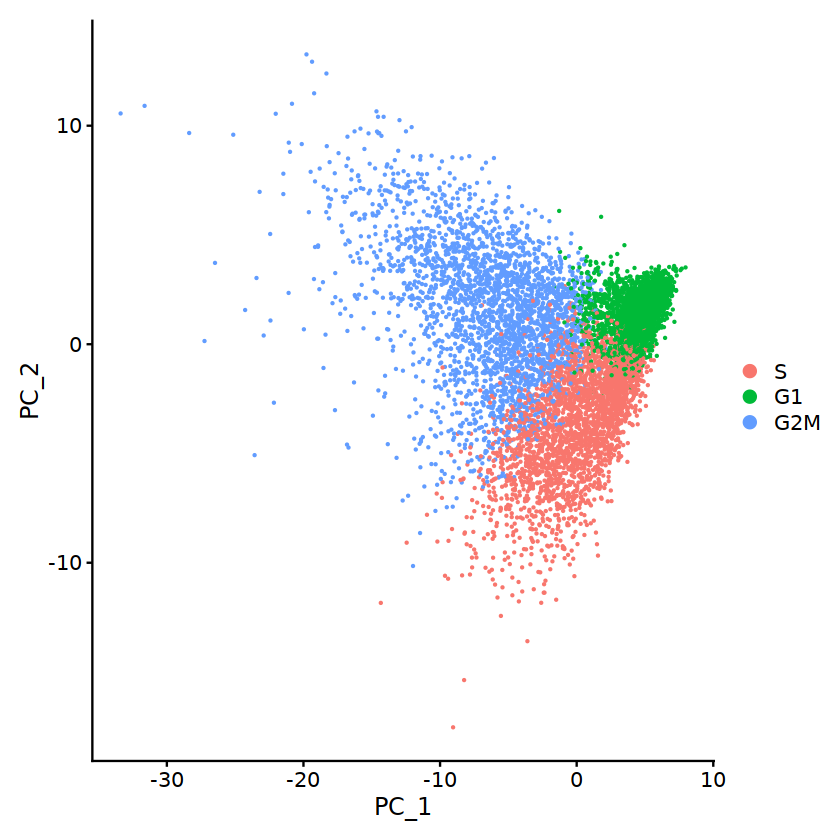

In [60]:
# determine cell cycle scores and plot
s.genes <- m.s.genes
g2m.genes <- m.g2m.genes
KO15 <- CellCycleScoring(KO15, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE) #presumably running on SCT assay, as it is the default Assay
KO15 <- RunPCA(KO15, features = c(s.genes, g2m.genes))
DimPlot(KO15)
ggsave(
  paste0("KO15_","CellCyclePCA","_","preRemoval", ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path,"cellcycle"),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [ ]:
# both approaches yield similar results, but first is conceptually more rigorous
# test.1 <- SCTransform(bmdm, vars.to.regress = c("percent.mt", "S.Score", "G2M.Score"), assay = 'RNA', new.assay.name = 'SCT', verbose = FALSE) #runs on same original assay.
# test.1 <- RunPCA(test.1, features = c(s.genes, g2m.genes))
# DimPlot(test.1)
# # OR
# test.2 <- SCTransform(bmdm, vars.to.regress = c("S.Score", "G2M.Score"), assay = 'SCT', new.assay.name = 'SCT', verbose = FALSE) #runs on the assay already normalized/transformed.
# test.2 <- RunPCA(test.2, features = c(s.genes, g2m.genes))
# DimPlot(test.2)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 19 features requested have not been scaled (running reduction without them): Wdr76, Ubr7, Pold3, Msh2, Cdc45, Exo1, Dscc1, Blm, Casp8ap2, Pola1, Brip1, Nuf2, Ckap2, Gtse1, Ttk, Cdc25c, Ect2, Ctcf, G2e3”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  Ube2c, Cdc20, Cenpa, Ccnb2, Tubb4b, Aurka, Ung, Cdca7, Cenpf, Cks1b 
	   Hells, Cdk1, Mcm2, Nasp, Kif2c, Dtl, Rpa2, Psrc1, Mcm4, Mcm6 
	   Tacc3, Nek2, Cdca8, Tpx2, Hmmr, Tipin, Mcm5, Cdc6, Cks2, Dlgap5 
Negative:  Mki67, Top2a, Aurkb, Kif11, Rrm2, Atad2, Tmpo, Anln, Ncapd2, Rrm1 
	   Smc4, Clspn, Cbx5, E2f8, Ndc80, Cdca2, Tyms, Ckap2l, Hjurp, Prim1 
	   Kif20b, Hmgb2, Bub1, Kif23, Ckap5, Rad51ap1, Chaf1b, Lbr, Nusap1, Fen1 
PC_ 2 
Positive:  Ube2c, Top2a, Cdk1, Aurkb, Mki67, Cenpf, Kif11, Rrm2, Nusap1, Smc4 
	   Cdca

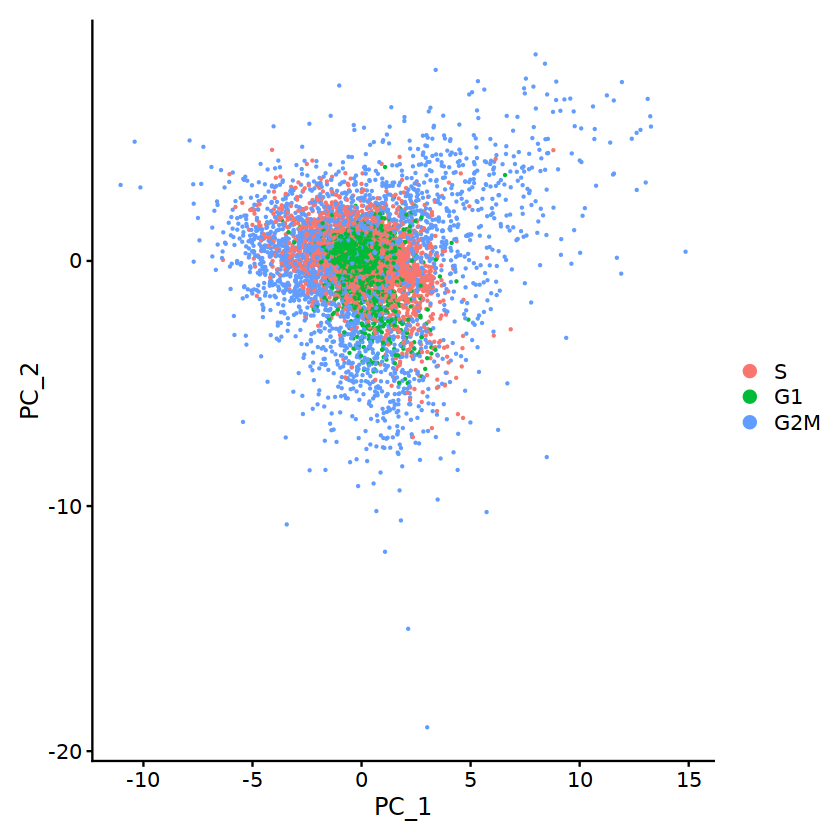

In [61]:
KO15 <- SCTransform(KO15, 
                     vars.to.regress = c("percent.mt", "S.Score", "G2M.Score"), 
                     assay = 'RNA', 
                     new.assay.name = 'SCT', 
                     verbose = FALSE,
                     method="glmGamPoi"
                    )#, min_cells = 1)
KO15 <- RunPCA(KO15, features = c(s.genes, g2m.genes))
DimPlot(KO15)
ggsave(
  paste0("KO15_","CellCyclePCA","_","postRemoval", ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path,"cellcycle"),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [62]:
# normalize Ab data
KO15 <- NormalizeData(KO15, normalization.method = "CLR", margin = 2, assay = "AB")

Normalizing across cells



In [63]:
# normalize guide RNA data
KO15 <- NormalizeData(KO15, normalization.method = "CLR", margin = 2, assay = "gRNA")

Normalizing across cells



# Dimred & plot

In [64]:
dir.create(file.path(results_path,"unsupervised"), showWarnings = FALSE)

In [65]:
# Run PCA & UMAP
KO15 <- RunPCA(KO15, verbose = FALSE)
KO15 <- RunUMAP(KO15, dims = 1:30, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [66]:
# Plot PCA & UMAP with discrete features (Dimplot)
features <- c("hto_demux", "batch", "KO_call", "Phase")

for (dimred in c("umap", "pca")){
    for (feature in features){
        if (feature=='KO_call'){
                DimPlot(KO15, reduction=dimred, label = FALSE, group.by=feature) + NoLegend()
        }else{
                DimPlot(KO15, reduction=dimred, label = FALSE, group.by=feature)
        }
#         DimPlot(PT149, reduction=dimred, label = FALSE, group.by=feature)
        ggsave(
          paste0("KO15_normalized_",dimred,"_",feature, ".svg"),
          plot = last_plot(),
          device = "svg",
          path = file.path(results_path,"unsupervised"),
          scale = 1,
          dpi = 300,
          limitsize = FALSE,
        )
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [69]:
# Plot PCA & UMAP colored by NT and Spi1-KO

KO15$NT_Spi1 <- KO15$KO_call
KO15$NT_Spi1[(KO15$NT_Spi1!='mSpi1') & (KO15$NT_Spi1!='mNon-targeting')] = 'other'
unique(KO15$NT_Spi1)

for (dimred in c("umap", "pca")){
    DimPlot(KO15, reduction=dimred, label = FALSE, group.by='NT_Spi1', cells = KO15$NT_Spi1!='other')

    ggsave(
      paste0("KO15_normalized_",dimred,"_NT_Spi1-KO", ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path,"unsupervised"),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

[1] "other"          "mNon-targeting" "mSpi1"

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [70]:
# Plot PCA & UMAP with continuous features (FeaturePlot)
features <- c("nCount_RNA", "nFeature_RNA", "nCount_AB", 'nFeature_AB','nCount_gRNA','nFeature_gRNA','nCount_HTO','nFeature_HTO','percent.mt')

for (dimred in c("umap", "pca")){
    for (feature in features){
        FeaturePlot(KO15, reduction=dimred, features = feature)
        ggsave(
          paste0("KO15_normalized_",dimred,"_",feature, ".svg"),
          plot = last_plot(),
          device = "svg",
          path = file.path(results_path,"unsupervised"),
          scale = 1,
          dpi = 300,
          limitsize = FALSE,
        )
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [71]:
# Plot PCA & UMAP with all continuous features simultaneously (FeaturePlot)
for (dimred in c("umap", "pca")){
    FeaturePlot(KO15, reduction=dimred, features = features)
    ggsave(
      paste0("KO15_normalized_",dimred,"_all", ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path,"unsupervised"),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        width=20,
        height=20
    )
}

In [10]:
# Plot PCA & UMAP with all AB features simultaneously (FeaturePlot)
features <- rownames(GetAssayData(object = KO15, assay='AB', slot = "counts"))

for (dimred in c("umap", "pca")){
    FeaturePlot(KO15, reduction=dimred, features = features)
    ggsave(
      paste0("KO15_AB_normalized_",dimred,"_all", ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path,"unsupervised"),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        width=20,
        height=20
    )
}

Warning message:
“Could not find CD115 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD11b in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD274 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD69 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD64 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD163 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD172a in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD14 in the default search locations, found in AB assay instead”
Warning message:
“Could not find CD80 in the default search locations, found in AB assay instead”
Warning message:
“Could not find Mac-2 in the default search locations, found in AB assay instead”
Warning messa

# save & load normalized Seurat object

In [72]:
# save Seurat object
saveRDS(KO15, file = file.path(results_path,paste0("KO15_normalized_Seurat.rds")))

In [5]:
# loading Seurat object
KO15 <-readRDS(file = file.path(results_path,paste0("KO15_normalized_Seurat.rds")))
KO15

An object of class Seurat 
45322 features across 9153 samples within 5 assays 
Active assay: SCT (14187 features, 3000 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 2 dimensional reductions calculated: pca, umap

In [74]:
# save matrix of SCT counts
SCT_counts <- GetAssayData(object = KO15, slot = "counts")
dim(SCT_counts)
write.csv(SCT_counts, file=file.path(results_path,paste0('KO15_SCT_counts','.csv')), row.names=TRUE)

[1] 14187  9153

In [13]:
# save metadata & normalized AB values
slot <- "data"
ab_flag <- "AB"
step <- "NORMALIZED"

# save metadata
write.csv(KO15[[]], file=file.path(results_path, paste0('KO15_',step,"_metadata",".csv")), row.names=TRUE)
# save normalized AB
write.csv(GetAssayData(object = KO15, slot = slot, assay = ab_flag), file=file.path(results_path, paste0('KO15_',step,'_',ab_flag,".csv")), row.names=TRUE)

# make cell count summary

In [77]:
unique(KO15$KO_call)

[1] "mStat1"         "mIrf8"          "mKdm1b"         "mNon-targeting"
 [5] "mHdac6"         "mIrf9"          "mTyk2"          "mcJun"         
 [9] "mStat2"         "mEp300"         "mKdm6b"         "mCsf1r"        
[13] "mRela"          "mSpi1"          "mCreb1"         "mJak1"

In [76]:
cell_numbers_df <- data.frame(matrix(ncol = 3, nrow=length(unique(KO15$KO_call))+1))
rownames(cell_numbers_df) <- c('all',unique(KO15$KO_call))
colnames(cell_numbers_df) <- unique(KO15$hto_demux)

In [79]:
# load, extract and save cell numbers per object
for (condition in unique(KO15$hto_demux)){
#     print(condition)
    
    # fill in sums of all cells
    cell_numbers_df['all',condition] <- sum(KO15$hto_demux==condition)
    
    # fill in NT cells
    cell_numbers_df['mNon-targeting', condition] <- sum(KO15$hto_demux==condition & KO15$KO_call=='mNon-targeting')
    
    for (KO_gene in unique(KO15$KO_call)){
        if (KO_gene=='mNon-targeting'){
            next
        }
        cell_numbers_df[KO_gene, condition] <- sum(KO15$hto_demux==condition & KO15$KO_call==KO_gene)
    }
}

head(cell_numbers_df)

,HTO-RAW-SZ_LO28_2h,HTO-RAW-SZ_untreated,HTO-RAW-SZ_LO28_6h
,<int>,<int>,<int>
all,3100,2981,3072
mStat1,160,184,213
mIrf8,191,163,186
mKdm1b,198,186,168
mNon-targeting,309,262,270
mHdac6,132,147,130


In [80]:
write.csv(cell_numbers_df, file=file.path(results_path,paste0('KO15_cell_count_summary','.csv')), row.names=TRUE)

In [81]:
sum(cell_numbers_df==0)

[1] 0

In [82]:
rowSums(cell_numbers_df)[1]

all 
9153

In [83]:
mean(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','mNon-targeting')),'HTO-RAW-SZ_untreated'])
mean(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','mNon-targeting')),'HTO-RAW-SZ_LO28_2h'])
mean(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','mNon-targeting')),'HTO-RAW-SZ_LO28_6h'])

[1] 181.2667

[1] 186.0667

[1] 186.8

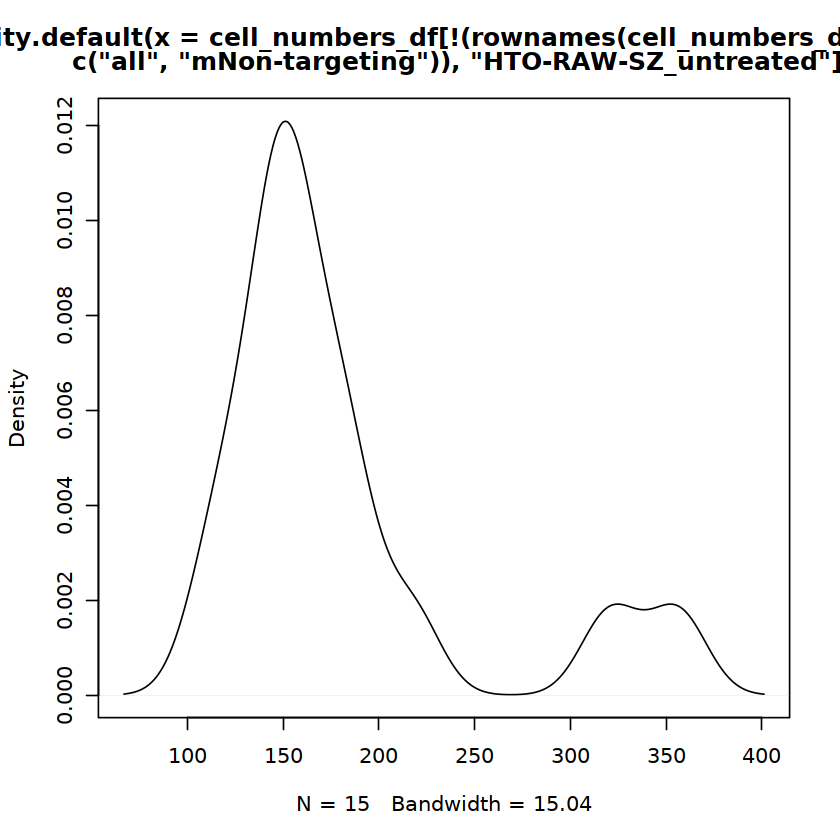

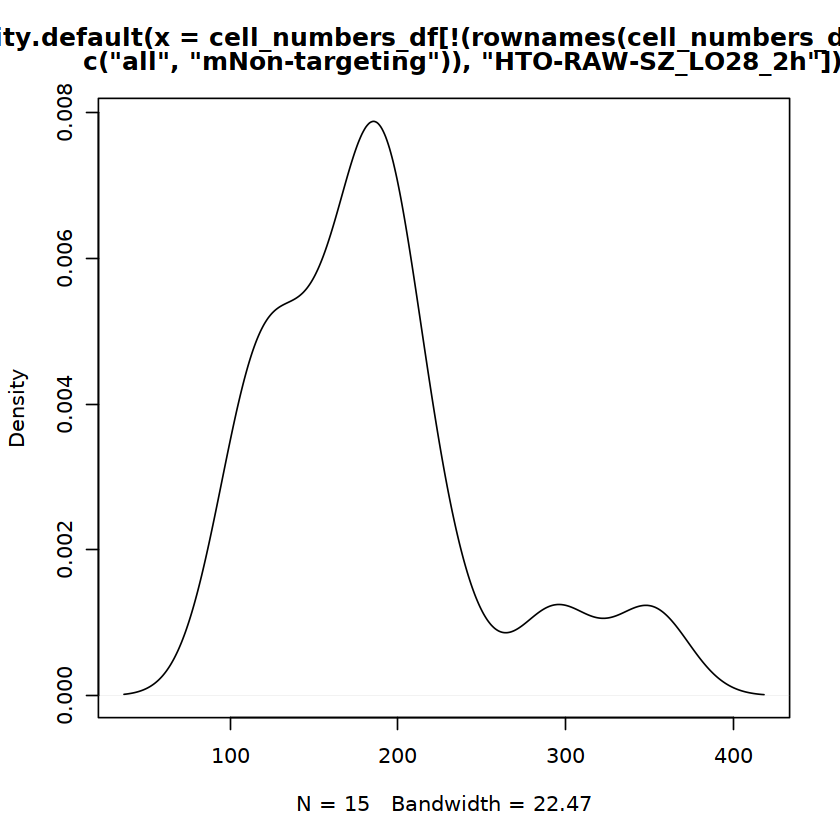

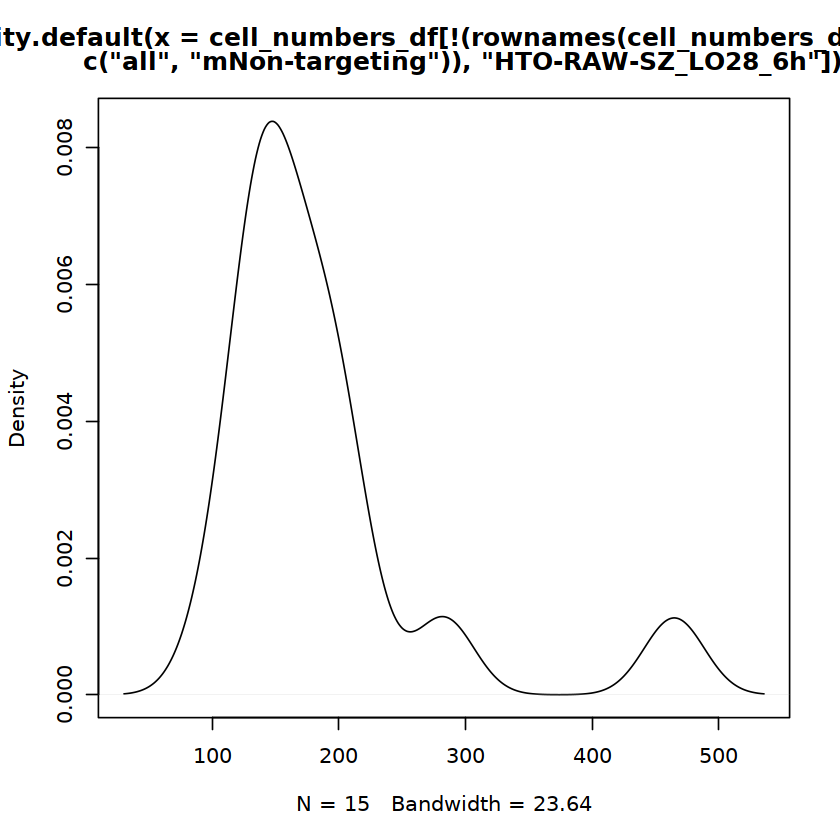

In [85]:
plot(density(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','mNon-targeting')),'HTO-RAW-SZ_untreated']))
plot(density(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','mNon-targeting')),'HTO-RAW-SZ_LO28_2h']))
plot(density(cell_numbers_df[!(rownames(cell_numbers_df) %in% c('all','mNon-targeting')),'HTO-RAW-SZ_LO28_6h']))

# interactive plot

In [87]:
library(plotly)


Attaching package: ‘plotly’


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [88]:
plot <- DimPlot(KO15, reduction='umap', label = FALSE, group.by='hto_demux')
p <- HoverLocator(plot = plot, information = FetchData(KO15, vars = colnames(KO15[[]])))#c("batch", "KO_call", "guide_call", "nFeature_RNA",'nCount_RNA','Phase', 'condition')))

In [89]:
htmlwidgets::saveWidget(as_widget(p), file.path(results_path,"unsupervised","index.html"))

Warning message in if (is.na(col)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(col)) {:
“the condition has length > 1 and only the first element will be used”
Warning message:
“`error_y.color` does not currently support multiple values.”
Warning message:
“`error_x.color` does not currently support multiple values.”
Warning message:
“`line.color` does not currently support multiple values.”
Warning message:
“The titlefont attribute is deprecated. Use title = list(font = ...) instead.”


## (Heatmap of) raw expression of KO genes in NT groups of each condition

In [90]:
KO_genes <- unique(KO15$KO_call)
KO_genes[8] <- "mJun"
KO_genes <- KO_genes[-4]
KO_genes <- substring(KO_genes, 2)
KO_genes

[1] "Stat1" "Irf8"  "Kdm1b" "Hdac6" "Irf9"  "Tyk2"  "Jun"   "Stat2" "Ep300"
[10] "Kdm6b" "Csf1r" "Rela"  "Spi1"  "Creb1" "Jak1"

In [91]:
DefaultAssay(KO15) <- 'RNA'
raw_counts <- GetAssayData(object = KO15, slot = "counts")
metric <- 'mean'
# metric <- 'median'

KO_gene_expr_df <- setNames(data.frame(matrix(ncol = 3, nrow = length(KO_genes))), unique(KO15$hto_demux))
rownames(KO_gene_expr_df) <- KO_genes

for (cond in unique(KO15$hto_demux)){
    for (KO_gene in KO_genes){
        if (metric=='mean'){
            mean_expr = mean(raw_counts[KO_gene, colnames(KO15)[KO15$KO_call=='mNon-targeting' & KO15$hto_demux==cond]])
        } 
        
        if (metric=='median'){
            mean_expr = median(raw_counts[KO_gene, colnames(KO15)[KO15$KO_call=='mNon-targeting' & KO15$hto_demux==cond]])
        }

        KO_gene_expr_df[KO_gene, cond] <- mean_expr
    }
}
# print(KO_gene_expr_df)
write.csv(KO_gene_expr_df, file=file.path(results_path,"qc",paste0('KO15_raw_RNA_KO_genes_NT',metric,'.csv')), row.names=TRUE)

In [92]:
KO_gene_expr_df

,HTO-RAW-SZ_LO28_2h,HTO-RAW-SZ_untreated,HTO-RAW-SZ_LO28_6h
,<dbl>,<dbl>,<dbl>
Stat1,0.95145631,1.32061069,2.80740741
Irf8,1.08090615,0.69083969,2.25555556
Kdm1b,0.02588997,0.07251908,0.02962963
Hdac6,0.09061489,0.06488550,0.06296296
Irf9,0.34627832,0.36641221,0.63703704
Tyk2,0.15210356,0.11450382,0.14444444
Jun,1.99352751,0.38931298,0.47037037
Stat2,0.31391586,0.39694656,1.19259259
Ep300,0.23624595,0.26335878,0.43333333


In [93]:
pdf(file=file.path(results_path,"qc",paste0("KO15_raw_RNA_KO_genes_NT",metric,".pdf")))
heatmap(data.matrix(KO_gene_expr_df) , scale = "none")
dev.off()

png 
  2

Saving 6.67 x 6.67 in image



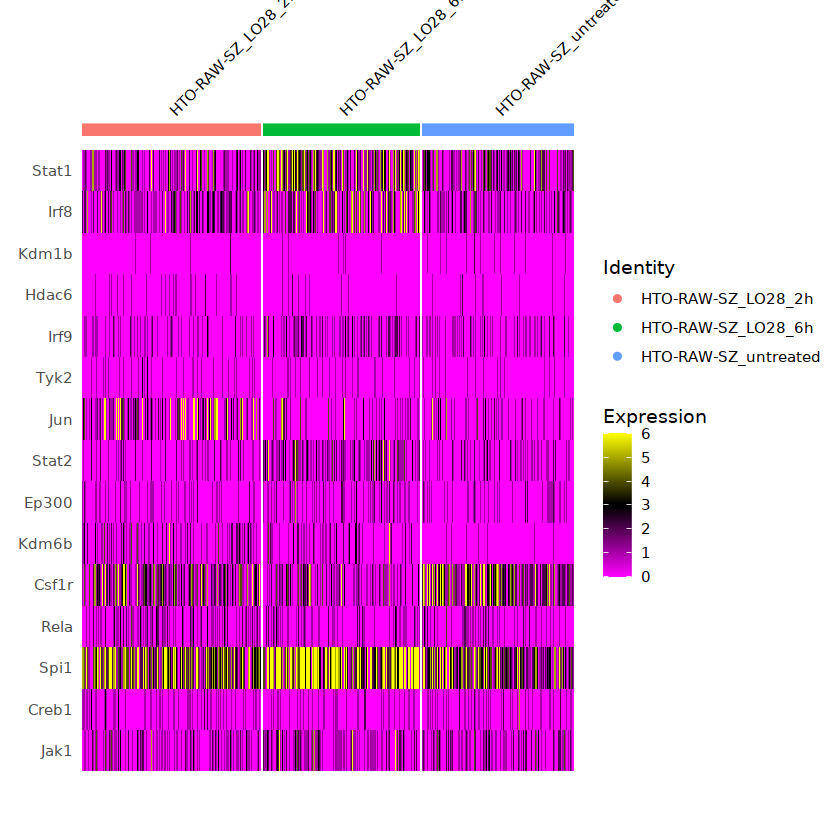

In [98]:
p <- DoHeatmap(
  KO15,
  features = KO_genes,
  cells = colnames(KO15)[KO15$KO_call=='mNon-targeting'],
  group.by = "hto_demux",
  group.bar = TRUE,
  group.colors = NULL,
  disp.min = -2.5,
  disp.max = NULL,
  slot = "count",
  assay = "RNA",
  label = TRUE,
  size = 3,
  hjust = 0,
  angle = 45,
  raster = TRUE,
  draw.lines = TRUE,
  lines.width = NULL,
  group.bar.height = 0.02,
  combine = TRUE
)

p

ggsave(
  paste0("KO15_raw_RNA_heatmap_KO_genes_NT",metric,".svg"),
  plot = p,
  device = "svg",
  path = file.path(results_path,"qc"),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)